In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import pi

import functorch
from matplotlib.colors import CenteredNorm
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.lenses import EPL, get_pix_jacobian
from caustic.sources import Sersic
from caustic.utils import get_meshgrid
from levmarq_torch import minimize_levmarq, minimize_levmarq_new


device = "cpu"

In [3]:
fov = 5.0
n_pix = 400
res = fov / n_pix
upsample_factor = 4
_thx_fine, _thy_fine = get_meshgrid(
    res / upsample_factor, upsample_factor * n_pix, upsample_factor * n_pix, device
)
thx, thy = get_meshgrid(res, n_pix, n_pix, device)

extent = (-fov / 2, fov / 2, -fov / 2, fov / 2)

In [4]:
lens = EPL(device)
src = Sersic(device)
z_l = torch.tensor(0.5, device=device)
z_s = torch.tensor(2.1, device=device)
cosmology = FlatLambdaCDMCosmology(device=device)
sigma_n = torch.tensor(20.0) * 0

In [5]:
def simulate(x_lens, x_src):
    """
    Args:
        x_lens: tensor of lens arguments.
        x_src: tensor of source arguments.
    """
    # Ray-trace
    beta_x, beta_y = lens.raytrace(
        _thx_fine, _thy_fine, z_l, z_s, cosmology, *x_lens
    )
    # Evaluate source
    mu_fine = src.brightness(beta_x, beta_y, *x_src)
    # Downsample
    mu = F.avg_pool2d(mu_fine[None, None, :, :], upsample_factor)[0, 0]
    # Add noise
    return mu + sigma_n * torch.randn_like(mu)

Test solver

In [6]:
# def kmeans(xs, k, n_iter):
#     # Initialize means with Forgy method
#     b = len(xs)
#     means = xs[torch.randperm(b)[:k]]
    
#     for _ in range(n_iter):
#         # E step: assign points to clusters
#         # Row: x index, col: mean index
#         d2s = ((xs[:, None, :] - means[None, :, :])**2).sum(-1)
#         idxs = d2s.argmin(-1)
#         # M step: update means
#         means = torch.stack([xs[idxs == i].mean(0) for i in range(4)])
    
#     return means


def get_cluster_means(xs, k):
    """
    Runs the k-means++ initialization algorithm.
    """
    b = len(xs)
    mean_idxs = [torch.randint(high=b, size=(), device=xs.device).item()]
    means = [xs[mean_idxs[0]]]
    for _ in range(1, k):
        unselected_xs = torch.stack([x for i, x in enumerate(xs) if i not in mean_idxs])
        
        # Distances to all means
        d2s = ((unselected_xs[:, None, :] - torch.stack(means)[None, :, :]) ** 2).sum(
            -1
        )
        
        # Distances to closest mean
        d2s_closest = torch.tensor([d2s[i, m] for i, m in enumerate(d2s.argmin(-1))])
        
        # Add point furthest from closest mean as next mean
        new_idx = d2s_closest.argmax().item()
        means.append(unselected_xs[new_idx])
        mean_idxs.append(new_idx)

    return torch.stack(means)

In [57]:
# EPL args: thx0, thy0, q, phi, b, t
x_lens = torch.tensor([0.0, 0.0, 0.8, pi / 6, 1.5, 1.1], device=device)
# Sersic args: thx0, thy0, q, phi, index, th_e, I_e
thx0_src = 0.14
thy0_src = 0.04
th_e = 0.01
x_src = torch.tensor([thx0_src, thy0_src, 1.0, 0.0, 4.0, th_e, 1.0], device=device)
mu = simulate(x_lens, x_src)

In [2]:
import torch

In [15]:
torch.tensor([5.0, 5.0])[None, :] * torch.rand(10, 2) + torch.tensor((-2.5, -2.5))[None, :]

tensor([[-2.1872, -1.0951],
        [ 1.9491,  0.4899],
        [ 0.8466, -0.8669],
        [-1.3856,  1.4479],
        [ 2.0346,  2.1166],
        [-0.8333, -0.1126],
        [-0.1398, -1.6306],
        [ 2.1214, -1.2801],
        [ 0.7647, -1.0792],
        [-1.4923,  1.5856]])

In [275]:
# %%timeit
# torch.manual_seed(9)
torch.manual_seed(12)

n_images = 4

# Source position
bxy = torch.tensor([thx0_src, thy0_src], device=device)


def get_beta_hat(thx, thy):
    return torch.stack(lens.raytrace(thx, thy, z_l, z_s, cosmology, *x_lens))


# Optimize with random guesses
n_guesses = 10
# while True:
thxy_0s = thxys = fov * (torch.rand(n_guesses, 2) - 0.5)
thxys = minimize_levmarq_new(
    thxys,
    bxy.repeat(len(thxys), 1),
    get_beta_hat,
    eps_metric=0.0,
    lam=1e-2,
    max_iters=2,
)

# # If the batch contains one point that optimizes poorly, the whole batch
# # can fail. If that happens, rerun with new guesses until it doesn't.
# if (thxys != thxy_0s).any():
#     break

# # Pare down to number of images
# thxys = get_cluster_means(thxys, n_images)

# # Run final optimization
# thxys = minimize_levmarq(
#     thxys, bxy.repeat(len(thxys), 1), get_beta_hat, max_iters=5
# )



# plt.figure(figsize=(10, 10))
# plt.imshow(
#     mu,
#     cmap="RdBu_r",
#     origin="lower",
#     extent=extent,
#     norm=CenteredNorm(halfrange=4)
# )
# plt.colorbar(fraction=0.046, pad=0.04)

# for thxy in thxy_0s:
#     plt.scatter(*thxy, marker="x", c="C1", lw=2)

# for thxy in thxys:
#     plt.scatter(*thxy, marker="o", fc="none", ec="C0", lw=2)

# plt.title("Orange 'x': initial positions; blue 'o': fit positions")

tensor([[[0.0007, 0.0000],
         [0.0000, 0.0125]],

        [[0.0503, 0.0000],
         [0.0000, 0.0285]],

        [[0.0009, 0.0000],
         [0.0000, 0.0112]],

        [[0.0028, 0.0000],
         [0.0000, 0.0098]],

        [[0.0064, 0.0000],
         [0.0000, 0.0060]],

        [[0.0084, 0.0000],
         [0.0000, 0.0037]],

        [[0.0193, 0.0000],
         [0.0000, 0.0167]],

        [[0.0006, 0.0000],
         [0.0000, 0.0116]],

        [[0.0078, 0.0000],
         [0.0000, 0.0049]],

        [[0.0116, 0.0000],
         [0.0000, 0.0003]]])
tensor([[[0.0075, 0.0000],
         [0.0000, 0.1380]],

        [[0.0004, 0.0000],
         [0.0000, 0.0010]],

        [[0.0094, 0.0000],
         [0.0000, 0.1229]],

        [[0.0307, 0.0000],
         [0.0000, 0.1074]],

        [[0.0702, 0.0000],
         [0.0000, 0.0659]],

        [[0.0928, 0.0000],
         [0.0000, 0.0409]],

        [[0.2125, 0.0000],
         [0.0000, 0.1839]],

        [[0.0070, 0.0000],
         [0.0000, 0.1

In [6]:
%timeit simulate(x_lens, x_src)

NameError: name 'x_lens' is not defined

In [21]:
fov = 5.0
n_pix = 10
res = fov / n_pix
upsample_factor = 10
_thx_fine, _thy_fine = get_meshgrid(
    res / upsample_factor, upsample_factor * n_pix, upsample_factor * n_pix, device
)
thx, thy = get_meshgrid(res, n_pix, n_pix, device)

extent = (-fov / 2, fov / 2, -fov / 2, fov / 2)

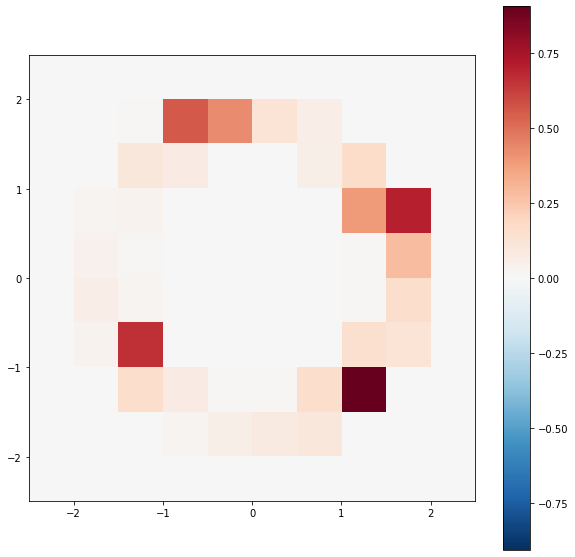

In [22]:
mu = simulate(x_lens, x_src)

plt.figure(figsize=(10, 10))
plt.imshow(
    mu,
    cmap="RdBu_r",
    origin="lower",
    extent=extent,
    norm=CenteredNorm()
)
plt.colorbar()

## Old/scratch

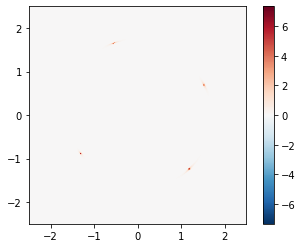

In [64]:
# EPL args: thx0, thy0, q, phi, b, t
x_lens = torch.tensor([0.0, 0.0, 0.8, pi / 6, 1.5, 1.1], device=device)
# Sersic args: thx0, thy0, q, phi, index, th_e, I_e
x_src = torch.tensor([0.03, 0.04, 0.6, pi / 4, 4.0, 0.01, 1.0], device=device)

# Simulate!
mu = simulate(x_lens, x_src)

# Plot
plt.imshow(
    mu,
    cmap="RdBu_r",
    vmin=-mu.abs().max(),
    vmax=mu.abs().max(),
    origin="lower",
    extent=extent,
)
plt.colorbar()

In [20]:
def fn(x):
    y = torch.ones_like(x)
    idxs = x > 0
    y[idxs] = 10.0
    return y

In [23]:
torch.maximum(torch.tensor([0., 1, 2, 3]), torch.tensor(1.5))

tensor([1.5000, 1.5000, 2.0000, 3.0000])

In [312]:
def minimize_levmarq(
    x,
    y,
    get_y_hat,
    eps_metric=0.1,
    lam=1e-2,
    eps_grad=None,
    eps_x=None,
    eps_reduced_chi2=None,
    lam_decrease_factor=9.0,
    lam_increase_factor=11.0,
    max_iters=10,
    small_number=0.0,
    lam_min=1e-7,
    lam_max=1e7,
):
    """
    Args:
        x: initial parameters.
        y: target data.
        get_y_hat: function taking components of `x` as arguments and returning a
            prediction of `y`.

    Notes:
        - Switch to jacfwd
        - Should be able to get value and Jacobian simultaneously
    """
    m = len(y)
    n = len(x)
    if m - n + 1 <= 0:
        raise ValueError(
            "number of data points must be at least the number of parameters minus 1"
        )

    argnums = tuple(range(n))
    hess_perturbation = small_number * torch.eye(n, device=x.device)
    chi2_prev = ((y - get_y_hat(*x)) ** 2).sum()

    for _ in range(max_iters):
        # Reduced chi^2 convergence check
        if eps_reduced_chi2 is not None and chi2 / (m - n + 1) < eps_reduced_chi2:
            break

        J = torch.stack(functorch.jacrev(get_y_hat, argnums)(*x))
        y_hat = get_y_hat(*x)
        dy = y - y_hat
        JT_dy = J.t() @ dy

        # Gradient convergence check
        if eps_grad is not None and JT_dy.max() < eps_grad:
            break

        # Propose an update
        JTJ = J.t() @ J
        hess_approx = (
            lam * torch.diag_embed(torch.diagonal(JTJ, dim1=-2, dim2=-1))
            + hess_perturbation
        )
        dx = torch.linalg.inv(JTJ + hess_approx) @ JT_dy

        # Parameter convergence check
        if eps_x is not None and (dx / (x + small_number)).abs().max() < eps_x:
            break

        x_new = x + dx
        chi2 = ((y - get_y_hat(*x_new)) ** 2).sum()
        # Decide whether to accept update
        metric = (chi2_prev - chi2) / (dx @ JT_dy + dx @ hess_approx @ dx).abs()
        if metric > eps_metric:
            x = x_new
            chi2_prev = chi2
            lam = max(lam / lam_decrease_factor, lam_min)
        else:
            lam = min(lam * lam_increase_factor, lam_max)

    return x

In [313]:
# Initial guess for image position
thx = torch.tensor(-0.7, device=device)
thy = torch.tensor(1.7, device=device)
thxy = torch.stack((thx, thy))

# Source position
bx = torch.tensor(0.03, device=device)
by = torch.tensor(0.04, device=device)
bxy = torch.stack((bx, by))

def get_beta_hat(thx, thy):
    return torch.stack(lens.raytrace(thx, thy, z_l, z_s, cosmology, *x_lens))

minimize_levmarq(thxy, bxy, get_beta_hat)

tensor([-0.5599,  1.6486])

In [359]:
# from icecream import ic


# def minimize_levmarq(
#     x,
#     y,
#     get_y_hat,
#     eps_metric=0.1,
#     lam=1e-2,
#     eps_grad=None,
#     eps_x=None,
#     eps_reduced_chi2=None,
#     lam_decrease_factor=9.0,
#     lam_increase_factor=11.0,
#     max_iters=10,
#     small_number=0.0,
#     lam_min=1e-7,
#     lam_max=1e7,
# ):
#     """
#     Levenberg-Marquardt minimizer, based on implementation 1 from `these notes <https://people.duke.edu/~hpgavin/ExperimentalSystems/lm.pdf>`_.
    
#     This minimizes :math:`|\\mathbf{y} - \\mathbf{\\hat{y}}(\\mathbf{x})|^2`, and is
#     batched over parameters `x` and datapoints `y`.

#     Args:
#         x: batch of initial parameters.
#         y: corresponding batch of target data.
#         get_y_hat: function taking components of `x` as arguments and returning a
#             prediction of `y`. Must be `vmap`able.
#         eps_metric: tolerance for deciding when to decrease :math:`\\lambda`.
#         lam: damping parameter :math:`\\lambda`.
#         eps_grad: gradient convergence threshold. If `None`, doesn't check this
#             convergence metric.
#         eps_x: parameter convergence threshold. If `None`, doesn't check this
#             convergence metric.
#         eps_reduced_chi2: reduced :math:`\\chi^2` convergence threshold. If `None`,
#             doesn't check this convergence metric.
#         lam_decrease_factor: factor by which to decrease :math:`\\lambda` after accepting
#             an update.
#         lam_increase_factor: factor by which to increase :math:`\\lambda` after rejecting
#             an update.
#         max_iters: maximum number of iterations.
#         small_number: this is added to the diagonal of the approximate Hessian and the
#             parameter values to avoid inverting a singular matrix or dividing by zero.
#         lam_min: minimum value permitted for :math:`\\lambda`.
#         lam_max: maximum value permitted for :math:`\\lambda`.

#     Notes:
#         - Switch to jacfwd
#         - Should be able to get value and Jacobian simultaneously
#     """
#     if len(x) != len(y):
#         raise ValueError("x and y must having matching batch dimension")

#     b, n = x.shape
#     m = y.shape[1]
#     if m - n + 1 <= 0:
#         raise ValueError(
#             "number of data points per batch must be at least the number of parameters "
#             "minus 1"
#         )

#     # Make vmapd functions
#     argnums = tuple(range(n))
#     get_y_hat_v = functorch.vmap(lambda x: get_y_hat(*x))
#     get_jac = functorch.vmap(lambda x: functorch.jacrev(get_y_hat, argnums)(*x))

#     hess_perturbation = small_number * torch.eye(n, device=x.device).repeat(b, 1, 1)
#     chi2_prev = ((y - get_y_hat_v(x)) ** 2).sum(-1)

#     for _ in range(max_iters):
#         # Reduced chi^2 convergence check
#         if eps_reduced_chi2 is not None and chi2.max() / (m - n + 1) < eps_reduced_chi2:
#             break

#         J = torch.stack(get_jac(x), -1)
#         y_hat = get_y_hat_v(x)
#         dy = (y - y_hat)[:, :, None]
#         JT_dy = J.transpose(-2, -1) @ dy  # [:, :, 0]

#         # Gradient convergence check
#         if eps_grad is not None and JT_dy.max() < eps_grad:
#             break

#         # Propose an update
#         JTJ = J.transpose(-2, -1) @ J
#         hess_approx = (
#             lam * torch.diag_embed(torch.diagonal(JTJ, dim1=-2, dim2=-1))
#             + hess_perturbation
#         )
#         dx = torch.linalg.inv(JTJ + hess_approx) @ JT_dy

#         # Parameter convergence check
#         if eps_x is not None and (dx / (x + small_number)).abs().max() < eps_x:
#             break

#         x_new = x + dx[:, :, 0]
#         chi2 = ((y - get_y_hat_v(x_new)) ** 2).sum()
#         # Decide whether to accept update
#         metric = (chi2_prev - chi2) / (
#             (dx * JT_dy).sum(-2)[:, 0] + (dx * (hess_approx @ dx)).sum(-2)[:, 0]
#         ).abs()
#         if metric.max() > eps_metric:
#             x = x_new
#             chi2_prev = chi2
#             lam = max(lam / lam_decrease_factor, lam_min)
#         else:
#             lam = min(lam * lam_increase_factor, lam_max)

#     return x